# SARIMA forecast models

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import os

## Preliminaries
### Load data into numpy arrays

In [2]:
path = os.getcwd()
path = os.path.join(path, "priceData2019To2024.csv")
price_df = pd.read_csv(path, sep=";")
price_df.columns = price_df.columns.str.strip()
price_df["time"] = pd.to_datetime(price_df["Datum"] + " " + price_df["von"], format="%d.%m.%Y %H:%M")
start_time = price_df["time"].min()
price_df["hours"] = (price_df["time"] - start_time).dt.total_seconds() / 60 / 60  # time in hours since beginning of file
price_df["price"] = price_df["Spotmarktpreis in ct/kWh"]
valid_rows = price_df[np.isfinite(price_df["price"])]
time = np.array(valid_rows["hours"].tolist())
price = np.array(valid_rows["price"].tolist())

### Split into training and test data

In [3]:
SAMPLES_PER_DAY = 24
PREDICTION_HORIZON = 24

# Test data
nTestSamples = int(366 * SAMPLES_PER_DAY)  # 2024 was a leap year
testData = price[-nTestSamples:]
testTime = time[-nTestSamples:]

# Training data
nTrainingSamples = price.size - nTestSamples
trainingData = price[:nTrainingSamples]
trainingTime = time[:nTrainingSamples]  # 1 hour sampling time

### Plot data

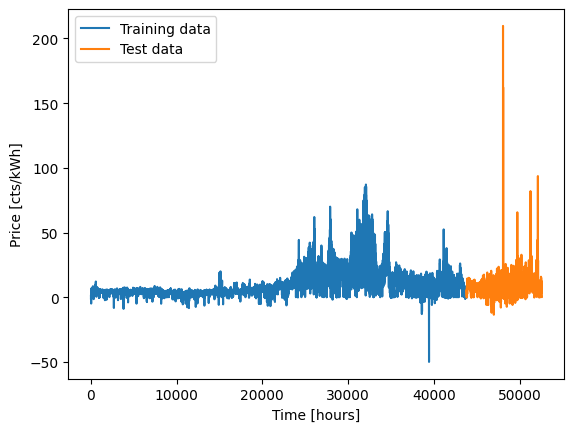

In [4]:
figure = plt.figure()
plt.plot(trainingTime, trainingData, label="Training data")
plt.plot(testTime, testData, label="Test data")
plt.xlabel("Time [hours]")
plt.ylabel("Price [cts/kWh]")
plt.legend()

### Plot autocorrelation

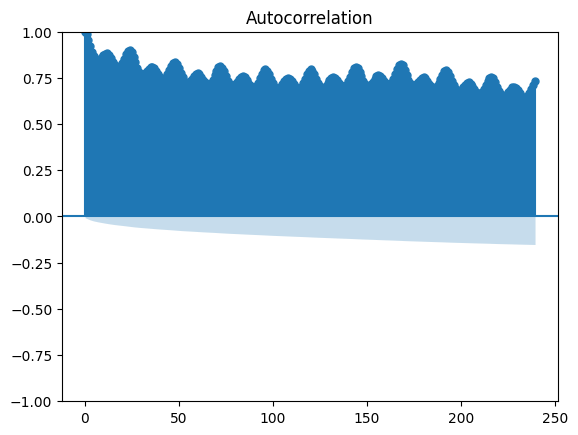

In [5]:
acf_size = SAMPLES_PER_DAY * 10
plot_acf(trainingData, lags=np.arange(acf_size))
pass  # this line stops duplicated plots in output


### Define function for plotting forecast results

In [6]:
def fitAndPlotForecast(
    trainingData,
    trainingTime,
    testData,
    testTime,
    arimaModel,
    title="Forecast",
    ylabel="Price [cts/kWh]",
):
    n_hist = SAMPLES_PER_DAY * 10
    n_pred = PREDICTION_HORIZON * 2

    trainedArimaModel = arimaModel.fit(method="innovations_mle")
    forecast = trainedArimaModel.get_forecast(n_pred)

    pastTime = trainingTime[-n_hist:]
    pastData = trainingData[-n_hist:]
    futureTime = testTime[0:n_pred]
    futureData = testData[0:n_pred]

    figure = plt.figure()
    plt.title(title)
    plt.plot(pastTime, pastData, label="Known past")
    plt.plot(futureTime, forecast.predicted_mean, label="Nominal forecast")
    plt.plot(futureTime, futureData, label="Unknown future")
    plt.legend()
    plt.xlabel("Time [hours]")
    plt.ylabel(ylabel)

    print(trainedArimaModel.summary())

    return trainedArimaModel

# Forecasting

## Persistence forecast

/var/folders/xn/tx4zptkn33sg6w3yk171m4k40000gp/T/ipykernel_47271/1563978713.py:13: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  trainedArimaModel = arimaModel.fit(method="innovations_mle")


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                43824
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -87542.282
Date:                Fri, 14 Mar 2025   AIC                         175086.564
Time:                        18:53:48   BIC                         175095.252
Sample:                             0   HQIC                        175089.302
                              - 43824                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.1816      0.007    467.999      0.000       3.168       3.195
Ljung-Box (L1) (Q):               11146.97   Jarque-Bera (JB):            595088.55
Prob(Q):                              0.00   Pr

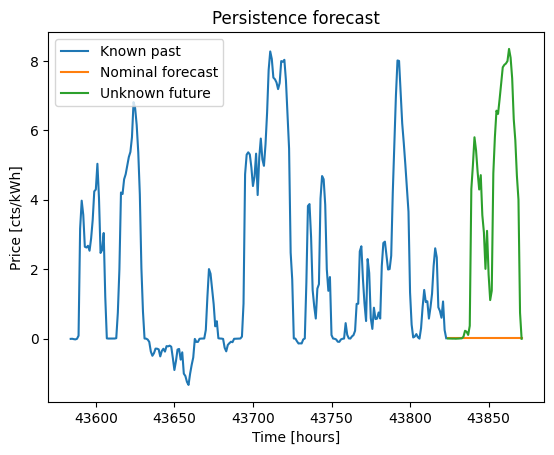

In [7]:
arima010 = ARIMA(endog=trainingData, order=(0, 1, 0), trend="n")
trainedArima010 = fitAndPlotForecast(
    trainingData,
    trainingTime,
    testData,
    testTime,
    arima010,
    title="Persistence forecast",
)

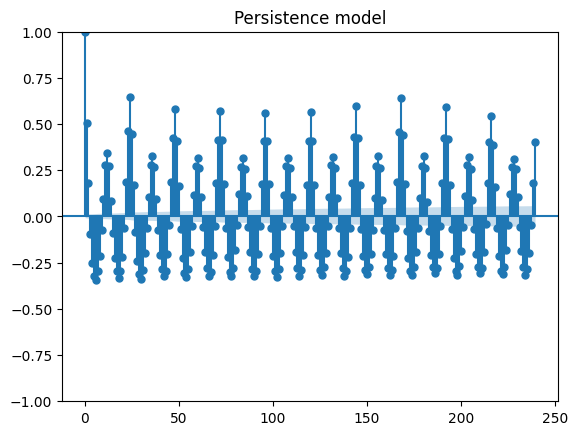

In [8]:
plot_acf(trainedArima010.resid, lags=np.arange(acf_size), title="Persistence model")
pass  # this line stops duplicated plots in output

## Seasonal persistence forecast

In [9]:
s = 24  # set the seasonal period

### ARIMA(0, 0, 0)(0, 1, 0)<sub>s</sub> without trend

/var/folders/xn/tx4zptkn33sg6w3yk171m4k40000gp/T/ipykernel_47271/1563978713.py:13: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  trainedArimaModel = arimaModel.fit(method="innovations_mle")


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                43824
Model:             ARIMA(0, 1, 0, 24)   Log Likelihood             -129495.604
Date:                Fri, 14 Mar 2025   AIC                         258993.209
Time:                        19:01:58   BIC                         259001.896
Sample:                             0   HQIC                        258995.947
                              - 43824                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        21.6534      0.052    415.248      0.000      21.551      21.756
Ljung-Box (L1) (Q):               39355.41   Jarque-Bera (JB):            345697.14
Prob(Q):                              0.00   Pr

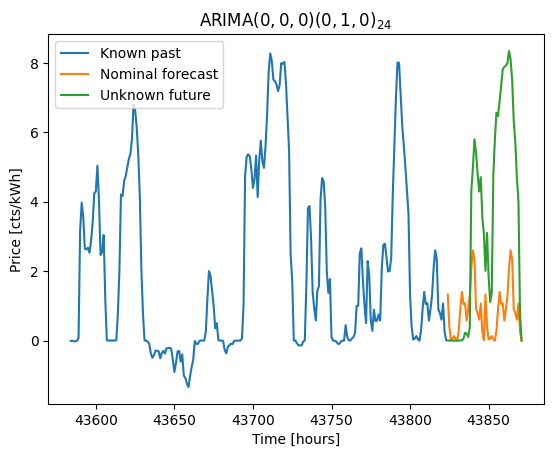

In [16]:
arima000010s = ARIMA(
    endog=trainingData, order=(0, 0, 0), seasonal_order=(0, 1, 0, s), trend="n"
)
trainedArima000010s = fitAndPlotForecast(
    trainingData,
    trainingTime,
    testData,
    testTime,
    arima000010s,
    title=f"ARIMA$(0, 0, 0)(0, 1, 0)_{{{s}}}$",
)

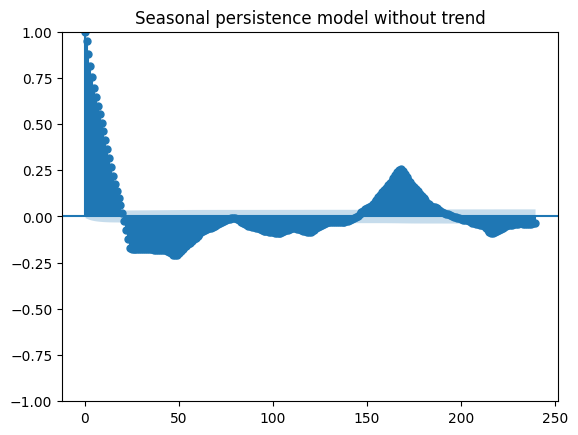

In [17]:
plot_acf(trainedArima000010s.resid, lags=np.arange(acf_size), title="Seasonal persistence model without trend")
pass  # this line stops duplicated plots in output

### ARIMA(0, 0, 0)(2, 0, 0)<sub>s</sub> with trend

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                43824
Model:             ARIMA(2, 0, 0, 24)   Log Likelihood             -127935.887
Date:                Fri, 14 Mar 2025   AIC                         255879.775
Time:                        19:04:31   BIC                         255914.526
Sample:                             0   HQIC                        255890.728
                              - 43824                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0004   7.57e-06     57.133      0.000       0.000       0.000
ar.S.L24       0.7779      0.002    344.344      0.000       0.773       0.782
ar.S.L48       0.1160      0.002     55.646      0.0

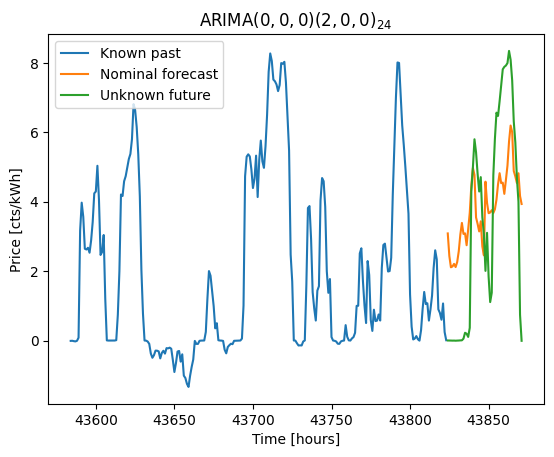

In [20]:
arima000200s = ARIMA(
    endog=trainingData, order=(0, 0, 0), seasonal_order=(2, 0, 0, s), trend="t"
)
trainedArima000200s = fitAndPlotForecast(
    trainingData,
    trainingTime,
    testData,
    testTime,
    arima000200s,
    title=f"ARIMA$(0, 0, 0)(2, 0, 0)_{{{s}}}$",
)

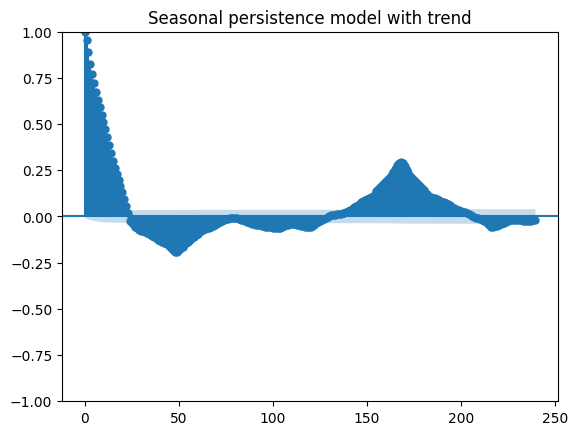

In [21]:
plot_acf(trainedArima000200s.resid, lags=np.arange(acf_size), title="Seasonal persistence model with trend")
pass  # this line stops duplicated plots in output

## Combination into ARIMA model

/Users/ruairi.moran@equipmentshare.com/Projects/spock.cu/spock.cu/.venv/lib/python3.10/site-packages/statsmodels/tsa/arima/estimators/gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                43824
Model:             ARIMA(1, 0, 0)x(1, 1, [1], 24)   Log Likelihood              -69438.830
Date:                            Fri, 14 Mar 2025   AIC                         138887.660
Time:                                    19:05:25   BIC                         138931.097
Sample:                                         0   HQIC                        138901.351
                                          - 43824                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0002      0.001     -0.273      0.785      -0.002       0.001
ar.L1          0.9689      0.000   

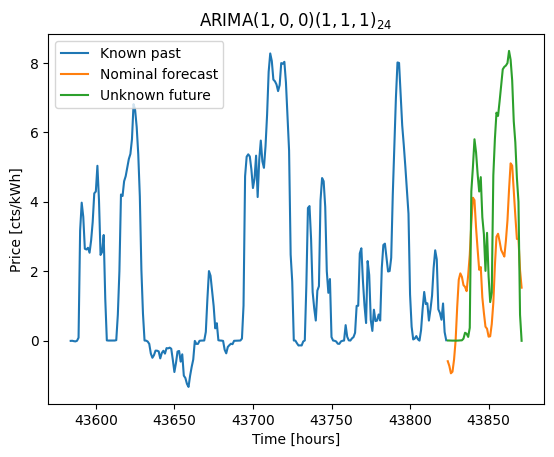

In [22]:
arima100111s = ARIMA(
    endog=trainingData, order=(1, 0, 0), seasonal_order=(1, 1, 1, s), trend="t"
)
trainedArima100111s = fitAndPlotForecast(
    trainingData,
    trainingTime,
    testData,
    testTime,
    arima100111s,
    title=f"ARIMA$(1, 0, 0)(1, 1, 1)_{{{s}}}$",
)

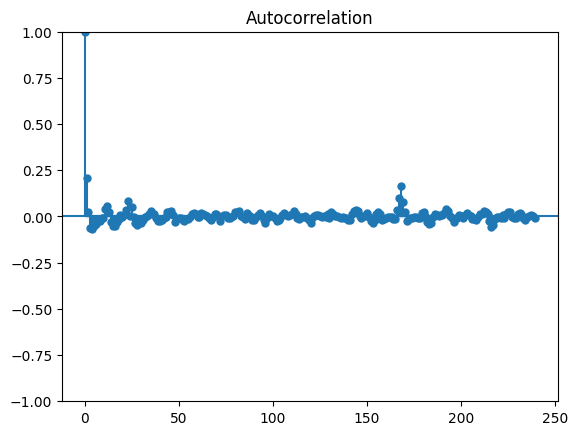

In [23]:
plot_acf(trainedArima100111s.resid, lags=np.arange(acf_size))
pass  # this line stops duplicated plots in output

# Out-of-sample analysis

### Define function for Prediction-Root-Mean-Square-Error (PRMSE)

In [ ]:
def calculatePrmse(
    trainedModel, testData, nTestSamples, forecastHorizon
):
    prmse = np.zeros(nTestSamples)
    for k in range(nTestSamples):
        forecast = trainedModel.forecast(forecastHorizon)
        actual = testData[k : k + forecastHorizon]
        error = actual - forecast
        prmse[k] = np.sqrt(1 / forecastHorizon * sum(error**2))
        trainedModel = trainedModel.extend(testData[k][None])
    return prmse

### Compute PRMSEs

In [ ]:
nTest = nTestSamples - PREDICTION_HORIZON
prmseArima010 =     calculatePrmse(trainedArima010,     testData, nTest, PREDICTION_HORIZON)
prmseArima000010s = calculatePrmse(trainedArima000010s, testData, nTest, PREDICTION_HORIZON)
prmseArima000200s = calculatePrmse(trainedArima000200s, testData, nTest, PREDICTION_HORIZON)
prmseArima100111s = calculatePrmse(trainedArima100111s, testData, nTest, PREDICTION_HORIZON)

### Compare model box plots

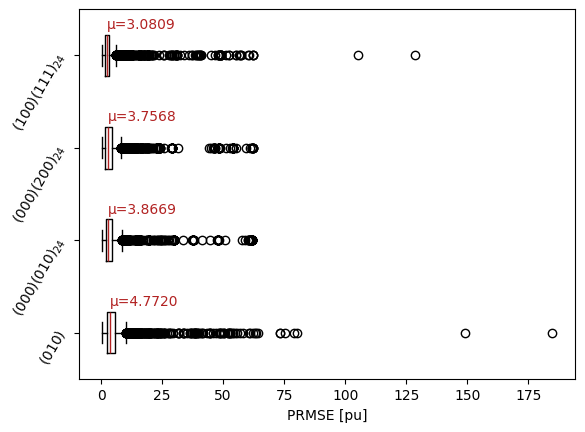

In [28]:
prmse = [
    prmseArima010,
    prmseArima000010s,
    prmseArima000200s,
    prmseArima100111s,
]
fig, ax = plt.subplots()
bp = ax.boxplot(prmse, vert=False, medianprops=dict(color="firebrick"))
plt.yticks(
    [1, 2, 3, 4],
    [
        "$(010)$",
        f"$(000)(010)_{{{s}}}$",
        f"$(000)(200)_{{{s}}}$",
        f"$(100)(111)_{{{s}}}$",
    ],
)
plt.yticks(rotation=60)
plt.xlabel("PRMSE [pu]")
mean = np.mean(prmse, axis=1)
for i, line in enumerate(bp["medians"]):
    x, y = line.get_xydata()[1]
    text = "μ={:.4f}".format(mean[i])
    ax.annotate(text, xy=(x - 0.02, y + 0.07), color="firebrick")

# So, what's the "best" model? (WIP)

In [ ]:
arima000200s = ARIMA(
    endog=trainingData, order=(0, 0, 0), seasonal_order=(2, 0, 0, s), trend="t"
)

# arima000200s48 = ARIMA(endog=trainingData, order=(2,1,2), seasonal_order=(0,0,0,0), exog=trainingData.shift([24, 168]))
# result = arima000200s48.fit()
# season ([24 and 168])
# order ([0, 5], [0, 1], [0, 5])

trainedArima000200s = fitAndPlotForecast(
    trainingData,
    trainingTime,
    testData,
    testTime,
    arima000200s,
    title=f"ARIMA$(0, 0, 0)(2, 0, 0)_{{{s}}}$",
)